In [1]:
import numpy as np
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

In [2]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

<ErrorbarContainer object of 3 artists>

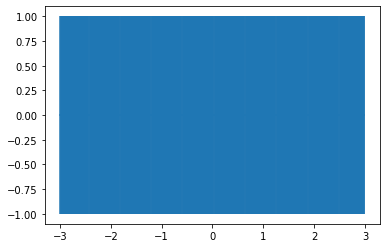

In [3]:
import matplotlib.pylab as plt
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)

In [4]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
print(y)

[1.025124811967751]


In [5]:
σ_1 = exponential_cov(x, x, θ)

In [6]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

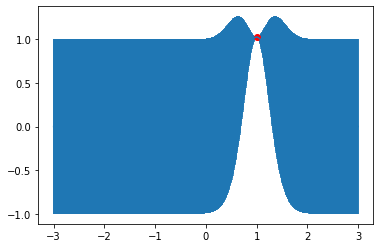

In [7]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [8]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
print(y2)

0.33367283529794184


In [9]:
x.append(-0.7)
y.append(y2)
σ_2 = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

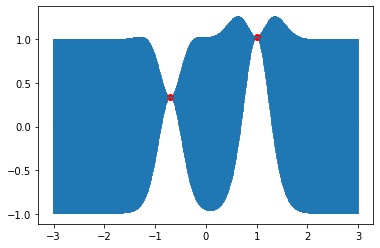

In [10]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [11]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
print(y_more)

[ 0.70477642 -1.07167795  1.56947069 -0.66665642  0.29195855]


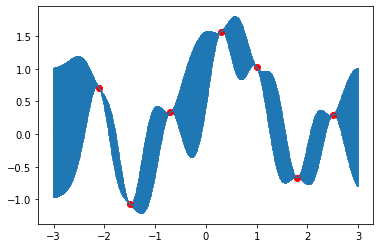

In [12]:
x += x_more
y += y_more.tolist()
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

## scikit.learns GP's

In [17]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [18]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [19]:
X = np.array(x).reshape(-1, 1)
print(X.shape)

(7, 1)


In [20]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)
gaussian_process.GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
n_restarts_optimizer=0, normalize_y=False,
optimizer='fmin_l_bfgs_b', random_state=None)

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\scikit_learn-0.24.2-py3.9-win-amd64.egg\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\scikit_learn-0.24.2-py3.9-win-amd64.egg\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GaussianProcessRegressor(kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1))

In [21]:
gp.kernel_
0.00316**2 + Matern(length_scale=1.11, nu=1.5) + WhiteKernel(noise_level=0.0912)

0.00316**2 + Matern(length_scale=1.11, nu=1.5) + WhiteKernel(noise_level=0.0912)

In [22]:
x_pred = np.linspace(-6, 6).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

## Gaussian Processes regression: basic introductory example

In [136]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

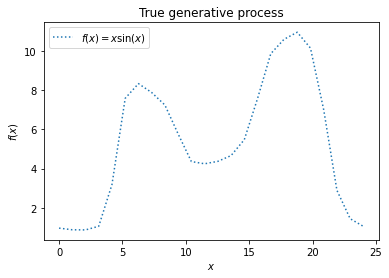

In [142]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [143]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [144]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.68**2 * RBF(length_scale=3.54)

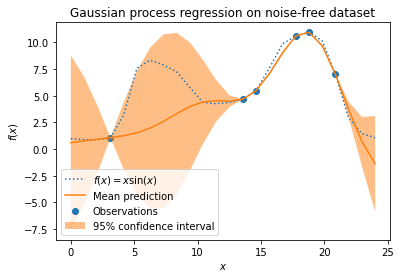

In [145]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

### Test 1


#### Generating Households Data

In [57]:
import time
import pandas as pd
import dask.dataframe as dd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as po
import plotly.express as px
import os,sys
import json
from array import array

from collections import defaultdict
from scipy.signal import find_peaks
# Insert the path of modules folder 
# sys.path.insert(0, 'C:/Users/Jason/thesis_project')
sys.path.append("../")

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


In [197]:
X = genX([1994,2014], drop_0 = True)

Xbin = xBins(X, 'amd')

dropping all zero rows


In [200]:
def selectRandomUser(Household):
    # # Find the household that logged the most data
    # ix = list_len.index(5283)

    # # Store the households ID
    # house_id = list_ids[ix]

    # print(house_id)
    house_id = Household
    # Create a dataframe with all of that households data
    A = X.loc[house_id,:]
    H = A.copy()

    return H

i = 2230
H = selectRandomUser(i)

In [ ]:
def describe_household():
       # Household ids
       id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

       for i in id:
              H = selectRandomUser(i)

              # H1 = find_peaksMA(H)
              H1_d = H.describe()

              H1_d = H1_d.drop(['count','std','min','max', '25%','50%','75%'])
              
            #   H1_d1 = find_peaksMA(H1_d)
              
       return H1_d

In [141]:
X = np.linspace(start=0, stop=24, num=24).reshape(-1, 1)

In [140]:
y = np.squeeze(H.values.reshape(-1,1))

In [127]:
H = describe_household()

#### Perform Gaussian Process Regression

In [146]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [147]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.68**2 * RBF(length_scale=3.54)

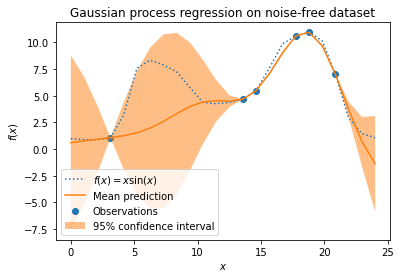

In [148]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

## Test 2

In [149]:
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(0, 30, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

In [150]:
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)
training_data = data[training_sample_indices]
training_noisy_target = target[training_sample_indices] + 0.5 * rng.randn(
    len(training_sample_indices)
)

In [172]:
training_sample_indices.shape

(40,)

In [166]:
training_noisy_target.shape

(40,)

In [167]:
training_data.shape

(40, 1)

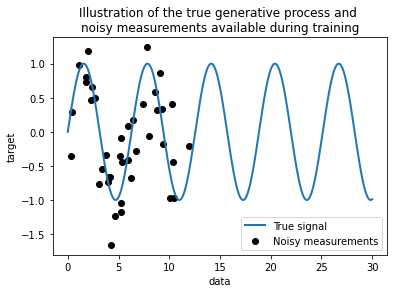

In [151]:
import matplotlib.pyplot as plt

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

In [160]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
import time
from sklearn.gaussian_process.kernels import ExpSineSquared

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(
    1e-1
)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
start_time = time.time()
gaussian_process.fit(training_data, training_noisy_target)
print(
    f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds"
)

Time for GaussianProcessRegressor fitting: 0.036 seconds


In [187]:
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    y,
    return_std=True,
)
print(
    f"Time for GaussianProcessRegressor predict: {time.time() - start_time:.3f} seconds"
)

Time for GaussianProcessRegressor predict: 0.001 seconds


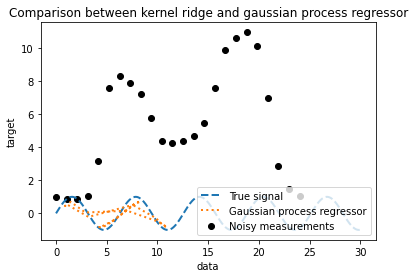

In [188]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    X,
    y,
    color="black",
    label="Noisy measurements",
)
# # Plot the predictions of the kernel ridge
# plt.plot(
#     data,
#     predictions_kr,
#     label="Kernel ridge",
#     linewidth=2,
#     linestyle="dashdot",
# )
# Plot the predictions of the gaussian process regressor
plt.plot(
    y,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
# plt.fill_between(
#     data.ravel(),
#     mean_predictions_gpr - std_predictions_gpr,
#     mean_predictions_gpr + std_predictions_gpr,
#     color="tab:green",
#     alpha=0.2,
# )
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Comparison between kernel ridge and gaussian process regressor")

In [168]:
H

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean,0.969639,0.884881,0.877994,1.064948,3.191459,7.583719,8.332049,7.879267,7.240885,5.765455,...,5.477357,7.571513,9.85606,10.590329,10.949886,10.141316,6.997578,2.8925,1.44807,1.05805


In [178]:
X = np.linspace(start=0, stop=24, num=24).reshape(-1, 1)
y = H.values.reshape(-1,1)

In [176]:
X.shape

(24, 1)

## Gaussian Process Regression using Scikit-learn (Python)
##### https://www.youtube.com/watch?v=QvcHrwXS4_U

In [206]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, WhiteKernel, ExpSineSquared as Exp, DotProduct as Lin


np.random.seed(1)

df = selectRandomUser(2230)

df_array = np.asarray(df.T)

In [207]:
df_array

array([[1.28016668, 1.92175   , 1.14525   , ..., 1.595     , 1.02208333,
        0.24025   ],
       [1.32774999, 1.88416667, 1.19725   , ..., 1.59275   , 1.017     ,
        0.23991666],
       [2.69599999, 1.25800001, 1.09033334, ..., 1.59408335, 1.01583336,
        0.24166666],
       ...,
       [5.10858335, 3.73616667, 2.52233331, ..., 4.49841668, 4.52766662,
        6.39150002],
       [1.74433335, 2.86949995, 1.065     , ..., 1.39341667, 0.36108333,
        3.34141667],
       [1.69891666, 1.43050001, 1.00308332, ..., 1.36658334, 0.23899999,
        1.44675001]])

In [248]:
day1 = df_array[0:,0]
day2 = df_array[0:,1]
day3 = df_array[0:,2]
day4 = df_array[0:,3]
day5 = df_array[0:,4]
day6 = df_array[0:,5]
day7 = df_array[0:,6]
day8 = df_array[0:,7]
day9 = df_array[0:,9]
day10 = df_array[0:,10]
day11 = df_array[0:,11]
day12 = df_array[0:,12]
day13 = df_array[0:,13]
# day14 = df_array[0:,14]
# day14 = df_array[0:,15]
# day15 = df_array[0:,16]
# day16 = df_array[0:,17]
# day17 = df_array[0:,18]
# day18 = df_array[0:,19]
# day19 = df_array[0:,20]
# day20 = df_array[0:,21]
# day21 = df_array[0:,22]



In [249]:
y = np.asarray([day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13]).T#,day14,day15,day16,day17,day18,day19,day20,day21]).T

In [250]:
y

array([[ 1.28016668,  1.92175   ,  1.14525   ,  0.99491666,  1.22091667,
         0.63374999,  1.36158333,  1.42949999,  1.20958332,  1.17758335,
         1.19191667,  0.88916668,  1.19850001],
       [ 1.32774999,  1.88416667,  1.19725   ,  1.08799999,  1.20608333,
         0.69116667,  1.44633331,  1.43116668,  0.96866666,  1.17449999,
         1.11391666,  1.11758335,  1.135     ],
       [ 2.69599999,  1.25800001,  1.09033334,  1.0695    ,  1.00208333,
         0.75783334,  1.20941665,  1.28625   ,  1.21408331,  1.49183334,
         1.04066667,  1.11266667,  0.90208334],
       [ 2.96341668,  1.48391668,  1.19433336,  1.28733333,  1.07066666,
         0.6335    ,  2.30008333,  1.31891667,  0.96083333,  1.82000001,
         0.89941667,  1.18008332,  0.82808333],
       [ 2.65566663,  1.40324999,  1.05766666,  1.49450001,  6.42575   ,
         2.7015    ,  3.70624997,  4.94774995,  0.98499999,  0.97425001,
        14.50341674,  3.4773333 ,  2.20916668],
       [ 8.41708338,  1.188500

In [251]:
X = np.atleast_2d([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]).T

In [252]:
x = np.atleast_2d(np.linspace(1,24,10739)).T

In [253]:
kernel = C()*Exp(length_scale = 24,periodicity = 1)

gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=100)

gp.fit(X,y)

y_pred_1, sigma_1 = gp.predict(x, return_std = True)

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\scikit_learn-0.24.2-py3.9-win-amd64.egg\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [254]:
kernel = C()*RQ(length_scale = 24, alpha = 1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

gp.fit(X,y)

y_pred_2, sigma_2 = gp.predict(x,return_std=True)

In [255]:
kernel = C()*Exp(length_scale=24,periodicity=1)*RQ(length_scale=24, alpha=0.5,length_scale_bounds=(1e-05,2),alpha_bounds = (1e-05,100_00.0))

gp = GaussianProcessRegressor(kernel = kernel,n_restarts_optimizer=100)

gp.fit(X,y)

y_pred_3, sigma_3 = gp.predict(x,return_std = True)

In [256]:
kernel = C()*RBF(length_scale=24,length_scale_bounds=(1e-05,2))*(RQ(length_scale=1, alpha = 0.5, length_scale_bounds=(1e-05,2),alpha_bounds=(1e-05,100000.0))+Exp(length_scale = 24, periodicity =1))

gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=100)

gp.fit(X,y)

y_pred_4, sigma_4 = gp.predict(x, return_std = True)

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\scikit_learn-0.24.2-py3.9-win-amd64.egg\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\site-packages\scikit_learn-0.24.2-py3.9-win-amd64.egg\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



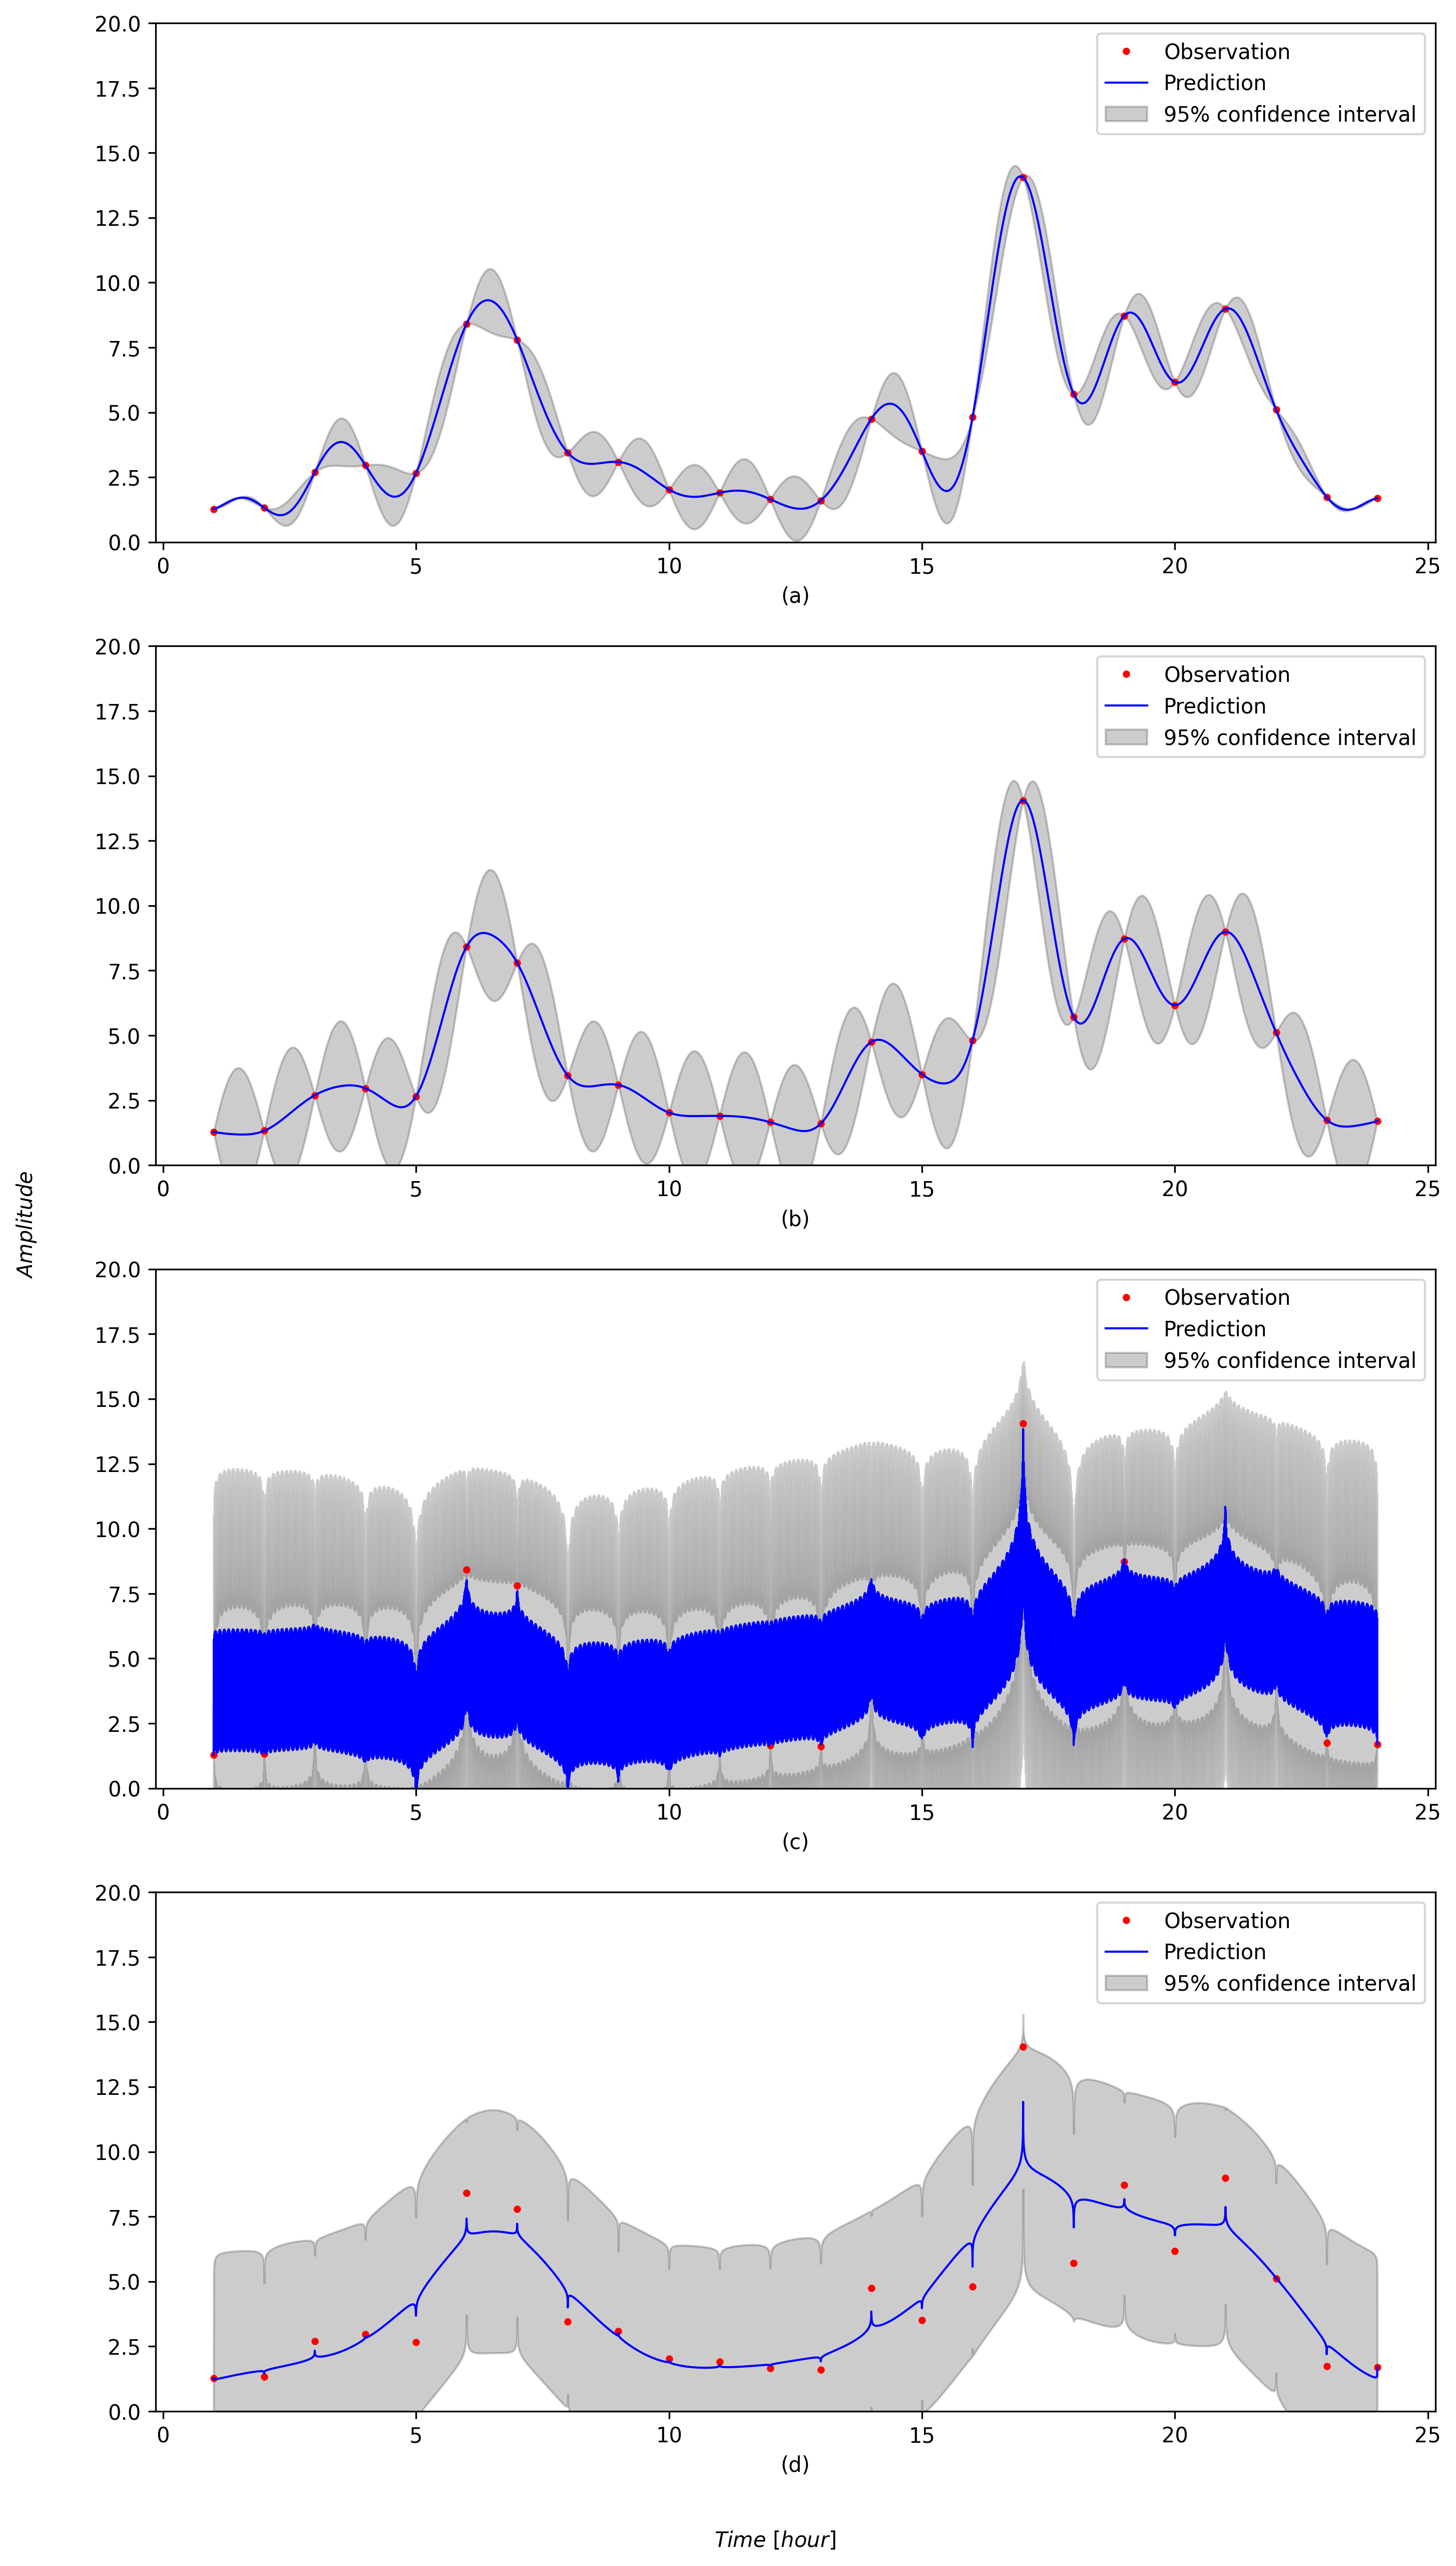

In [257]:
#Plot Figure
fig = plt.figure(num = 1, figsize = (11,0.8), dpi = 300, facecolor = 'w', edgecolor='k')
fig.text(0.5,-1,'$Time\ [hour]$', ha = 'center')
fig.text(0.04,10,'$Amplitude$',va = 'center', rotation = 'vertical')

plt.subplot(4,1,1)
plt.plot(X, y[:,0],'r.', markersize = 5,label =u'Observation')
plt.plot(x,y_pred_1[:,0],'b-',linewidth=1,label=u'Prediction')
plt.fill_between(x[:,0],y_pred_1[:,0]-1.96*sigma_1, y_pred_1[:,0]+1.96*sigma_1, alpha = 0.2, color= 'k', label = u'95% confidence interval')
plt.xlabel('(a)')
plt.legend(loc = 'upper right', fontsize = 10)
plt.ylim(0,20)

plt.subplot(4,1,2)
plt.plot(X, y[:,0],'r.', markersize = 5,label =u'Observation')
plt.plot(x,y_pred_2[:,0],'b-',linewidth=1,label=u'Prediction')
plt.fill_between(x[:,0],y_pred_2[:,0]-1.96*sigma_2, y_pred_2[:,0]+1.96*sigma_2, alpha = 0.2, color= 'k', label = u'95% confidence interval')
plt.xlabel('(b)')
plt.legend(loc = 'upper right', fontsize = 10)
plt.ylim(0,20)

plt.subplot(4,1,3)
plt.plot(X, y[:,0],'r.', markersize = 5,label =u'Observation')
plt.plot(x,y_pred_3[:,0],'b-',linewidth=1,label=u'Prediction')
plt.fill_between(x[:,0],y_pred_3[:,0]-1.96*sigma_3, y_pred_3[:,0]+1.96*sigma_3, alpha = 0.2, color= 'k', label = u'95% confidence interval')
plt.xlabel('(c)')
plt.legend(loc = 'upper right', fontsize = 10)
plt.ylim(0,20)

plt.subplot(4,1,4)
plt.plot(X, y[:,0],'r.', markersize = 5,label =u'Observation')
plt.plot(x,y_pred_4[:,0],'b-',linewidth=1,label=u'Prediction')
plt.fill_between(x[:,0],y_pred_4[:,0]-1.96*sigma_4, y_pred_4[:,0]+1.96*sigma_4, alpha = 0.2, color= 'k', label = u'95% confidence interval')
plt.xlabel('(d)')
plt.legend(loc = 'upper right', fontsize = 10)
plt.ylim(0,20)

plt.subplots_adjust(top = 20)

# plt.savefig('all_in.png', bbox_inches = 'tight')

